## Imports

In [1]:
from constants import ORIGINAL_FLUXES_FILE, \
                      ORIGINAL_SLM_FOLDER, \
                      ORIGINAL_AMPLITUDE_FILENAME, \
                      ORIGINAL_PHASE_FILENAME, \
                      TRAIN_FC_FLUXES_PATH, \
                      TRAIN_FC_AMP_PHASE_PATH, \
                      VALIDATION_FC_FLUXES_PATH, \
                      VALIDATION_FC_AMP_PHASE_PATH

from data_utils import load_numpy_data, normalize_data, flatten_data, fuse_amplitude_and_phase
                    

from plot_utils import plot_map, \
                       plot_model_history, \
                       plot_fully_connected_amp_phase_prediction

from modeling_utils import create_fully_connected_architecture_for_amplitude_and_phase_reconstruction, \
                           compile_model, \
                           train_model, \
                           train_model_with_generator, \
                           store_model

import numpy as np

from configurations import SimpleFCModel as ModelConfig

2024-02-15 11:33:35.889889: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-15 11:33:35.936274: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 11:33:35.936306: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 11:33:35.937452: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-15 11:33:35.945615: I tensorflow/core/platform/cpu_feature_guar

## Load data

In [2]:
train_flux_array = load_numpy_data(ORIGINAL_FLUXES_FILE)

amps = []
phases = []
for i in [8]:
    
    train_amp_array = load_numpy_data(f"{ORIGINAL_SLM_FOLDER}03/{ORIGINAL_AMPLITUDE_FILENAME}")
    amps.append(train_amp_array)
    train_phase_array = load_numpy_data(f"{ORIGINAL_SLM_FOLDER}03/{ORIGINAL_PHASE_FILENAME}")
    phases.append(train_phase_array)

train_amp_array = np.concatenate(amps, axis=0)
train_phase_array = np.concatenate(phases, axis=0)

val_amp_array = load_numpy_data(f"{ORIGINAL_SLM_FOLDER}07/{ORIGINAL_AMPLITUDE_FILENAME}")
val_phase_array = load_numpy_data(f"{ORIGINAL_SLM_FOLDER}07/{ORIGINAL_PHASE_FILENAME}")

In [3]:
train_flux_array, scaler = normalize_data(train_flux_array)

train_amp_array, scaler = normalize_data(train_amp_array)
val_amp_array, scaler = normalize_data(val_amp_array)

train_phase_array, scaler = normalize_data(train_phase_array)
val_phase_array, scaler = normalize_data(val_phase_array)

In [4]:
train_fluxes_array = flatten_data(train_flux_array)[30000:40000]
validation_fluxes_array = flatten_data(train_flux_array)[70000:80000]

In [5]:
train_amp_phase_array = fuse_amplitude_and_phase(train_amp_array, train_phase_array, axis=1)
validation_amp_phase_array = fuse_amplitude_and_phase(val_amp_array, val_phase_array, axis=1)

## Define configuration

In [6]:
model_configuration = ModelConfig()
print(model_configuration.get_description())


	=== FC-08-Original ===
	*ARCHITECTURE HYPERPARAMETERS:
		-Fully Connected
		-Input shape: 1320
		-Output shape: (2, 96, 96)
		-Hidden layers: [2000, 2000, 2000, 2000]
		-Regularizer: None
		-Hidden Layers Activation: relu
		-Output Layer Activation: linear
		-Batch Normalization: False
		-Dropout: False, 0.2
	
	*COMPILATION HYPERPARAMETERS:
		-Optimizer: ADAM lr=0.001, beta_1=0.9, beta_2=0.999
		-Loss Function: MSE
		-Metric: MSE
	
	* TRAINING HYPERPARAMETERS:
		-Epochs: 200
		-Batch size: 64
		-Callbacks: 
			-ReduceLROnPlateau: MSE 10 x0.1
			-Early Stop: MSE 25
	


2024-02-15 11:33:52.371337: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-15 11:33:52.520688: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-15 11:33:52.521557: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Instantiate model

In [7]:
model = create_fully_connected_architecture_for_amplitude_and_phase_reconstruction(
    *model_configuration.unpack_architecture_hyperparameters()
)


Model: "FC-08-Original"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2000)              2640000   
                                                                 
 activation (Activation)     (None, 2000)              0         
                                                                 
 dense_1 (Dense)             (None, 2000)              4000000   
                                                                 
 activation_1 (Activation)   (None, 2000)              0         
                                                                 
 dense_2 (Dense)             (None, 2000)              4000000   
                                                                 
 activation_2 (Activation)   (None, 2000)              0         
                                                                 
 dense_3 (Dense)             (None, 2000)           

## Compile model

In [8]:
compile_model(
    model,
    *model_configuration.unpack_compilation_hyperparameters()
)

## Train model

In [9]:
validation_amp_phase_array[0].shape

(2, 96, 96)

In [10]:
history = train_model(model, 
                      train_fluxes_array, 
                      train_amp_phase_array, 
                      validation_fluxes_array, 
                      validation_amp_phase_array,
                      *model_configuration.unpack_training_hyperparameters()
                    )


Epoch 1/200


2024-02-15 11:33:59.156758: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-15 11:34:00.191353: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe3d193ee60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-15 11:34:00.191443: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-02-15 11:34:00.211456: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-15 11:34:00.257651: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1707957240.747438   41860 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


157/157 [==============================] - 14s 62ms/step - loss: 0.6547 - mean_squared_error: 0.6547 - val_loss: 0.6313 - val_mean_squared_error: 0.6313 - lr: 0.0010
Epoch 2/200
157/157 [==============================] - 6s 35ms/step - loss: 0.6277 - mean_squared_error: 0.6277 - val_loss: 0.6285 - val_mean_squared_error: 0.6285 - lr: 0.0010
Epoch 3/200
157/157 [==============================] - 6s 35ms/step - loss: 0.6278 - mean_squared_error: 0.6278 - val_loss: 0.6265 - val_mean_squared_error: 0.6265 - lr: 0.0010
Epoch 4/200
157/157 [==============================] - 5s 34ms/step - loss: 0.6264 - mean_squared_error: 0.6264 - val_loss: 0.6280 - val_mean_squared_error: 0.6280 - lr: 0.0010
Epoch 5/200
157/157 [==============================] - 6s 35ms/step - loss: 0.6267 - mean_squared_error: 0.6267 - val_loss: 0.6273 - val_mean_squared_error: 0.6273 - lr: 0.0010
Epoch 6/200
157/157 [==============================] - 5s 35ms/step - loss: 0.6262 - mean_squared_error: 0.6262 - val_loss: 0.

## Results

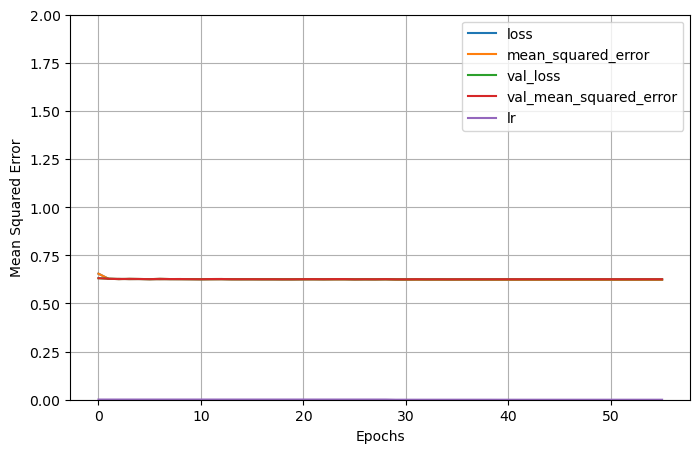

In [11]:
plot_model_history(history)

1/1 [==============================] - 0s 186ms/step


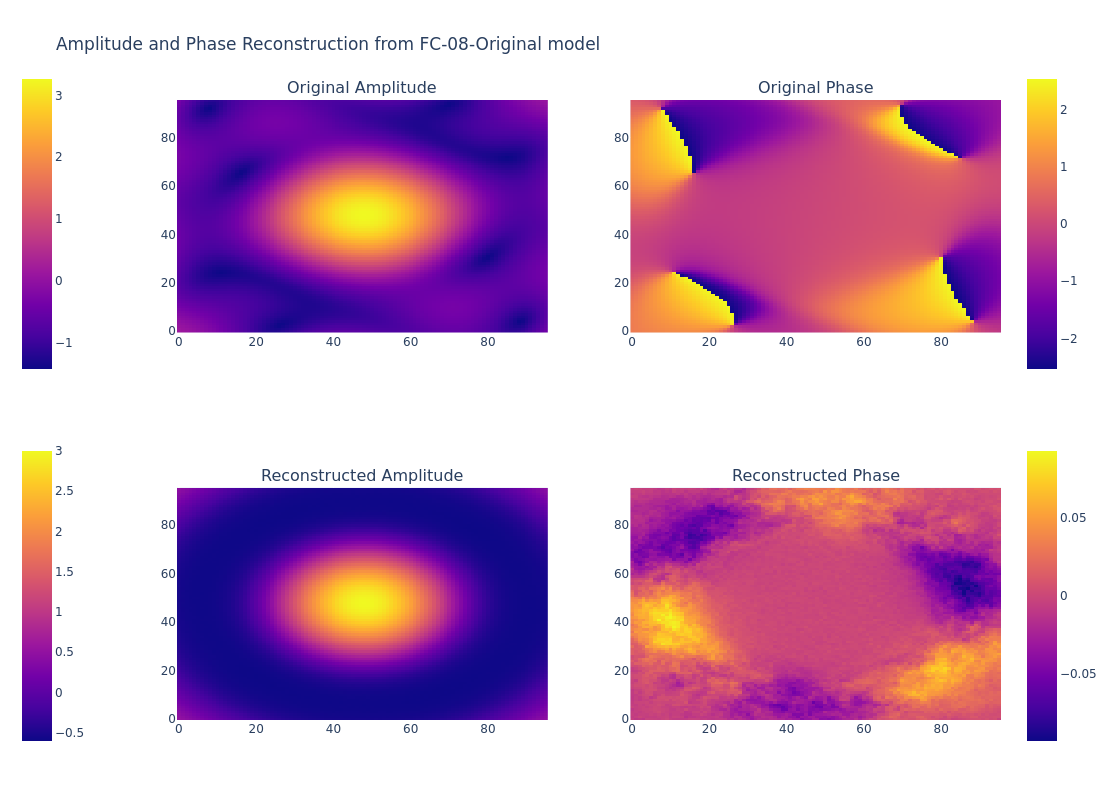

In [12]:
n = 106
plot_fully_connected_amp_phase_prediction(
    model,
    validation_fluxes_array[n],
    validation_amp_phase_array[n][0],
    validation_amp_phase_array[n][1]
    )

1/1 [==============================] - 0s 31ms/step


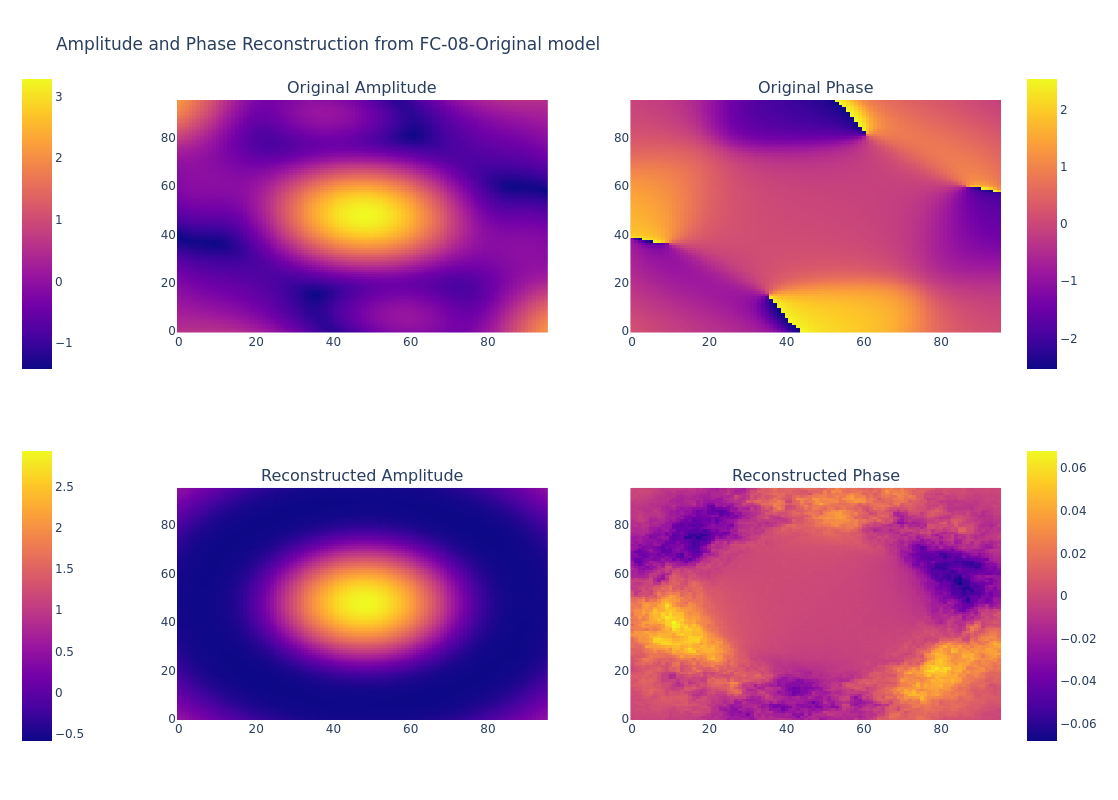

In [13]:
n = 106
plot_fully_connected_amp_phase_prediction(
    model,
    train_fluxes_array[n],
    train_amp_phase_array[n][0],
    train_amp_phase_array[n][1]
    )

In [14]:
#store_model(model,
            model.name,
            model_configuration.get_description(),
            history.history['mean_squared_error'][-1],
            history.history['val_mean_squared_error'][-1])

IndentationError: unexpected indent (3399709207.py, line 2)